# PXD012477
## Proteomic analyses of urine for healty ageing study

[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD012477)

[Article link](https://link.springer.com/article/10.1007/s11357-020-00269-y)

In [1]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

In [3]:
first = pd.read_csv('/home/robbe/ionbot/mastersets/PXD012477_first.csv')
first.head()

,Unnamed: 0,ionbot_match_id,spectrum_title,scan,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,...,Organism,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting
0,0,0_4121_1,controllerType=0 controllerNumber=1 scan=10001,10001,1DLC0080815QE_RRAG_001_rep1,879.42991,8794.3378,2170.70418,2,IDGSVDFK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
1,1,0_4122_1,controllerType=0 controllerNumber=1 scan=10002,10002,1DLC0080815QE_RRAG_001_rep1,1177.60447,11766.0599,2170.83888,2,EITAIAPSTMK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
2,2,0_4123_2,controllerType=0 controllerNumber=1 scan=10003,10003,1DLC0080815QE_RRAG_001_rep1,986.50168,9855.0146,2170.97352,2,IPACIAGER,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
3,3,0_4126_2,controllerType=0 controllerNumber=1 scan=10007,10007,1DLC0080815QE_RRAG_001_rep1,844.44016,8444.4428,2171.58480,2,FPETVPR,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
4,4,0_4128_1,controllerType=0 controllerNumber=1 scan=10011,10011,1DLC0080815QE_RRAG_001_rep1,1791.87363,18058.9815,2172.40680,2,VPEPCPSTVTPAPAQQK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First


In [4]:
del first["Unnamed: 0"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

In [5]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  5737728
The amount of raw files that make up the master dataset is:  489


In [6]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [7]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,Healthy Ageing,0,0,None,0,0,2706289
1,Non-Healthy Ageing,0,0,None,0,0,3031439


In [8]:
H = first.loc[lambda first: first["Oxidant treatment"] == "Healthy Ageing"]
NH = first.loc[lambda first: first["Oxidant treatment"] == "Non-Healthy Ageing"]

In [9]:
print("There are this many replicates of Healthy Ageing treatment: {}".format(H["spectrum_file"].nunique()))
print("There are this many replicates of Non-Healthy Ageing treatment: {}".format(NH["spectrum_file"].nunique()))

There are this many replicates of Healthy Ageing treatment: 234
There are this many replicates of Non-Healthy Ageing treatment: 255


In [10]:
Hrep = OA.replicate_filter(H, 117)
NHrep = OA.replicate_filter(NH, 128)

### Oxidatively modified PSMs

In [10]:
print("The ratio of PSMs that contain an oxidative modification in the Healthy Ageing treatment subset: {}".format((Hrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Non-Healthy Ageing treatment subset: {}".format((NHrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Healthy Ageing treatment subset: 7.934462589859209 %
The ratio of PSMs that contain an oxidative modification in the Non-Healthy Ageing treatment subset: 9.153490894450684 %


In [11]:
mrHrep = OA.modratios(Hrep)
mrNHrep = OA.modratios(NHrep)

In [12]:
modr = pd.merge(mrNHrep, mrHrep, on="Modification", suffixes=('_NH', '_H'))
modr["Difference"] = modr["Ratios_NH"] - modr["Ratios_H"]
modr = modr.drop(modr[(modr["Ratios_NH"] == 0) | (modr["Ratios_H"] == 0)].index)


,Modification,Ratios_NH,Ratios_H,Difference
0,[35]Oxidation[T],0.001096,0.000577,5.190632e-04
1,[35]Oxidation[E],0.001596,0.000947,6.486166e-04
2,[35]Oxidation[S],0.000490,0.000162,3.285756e-04
3,[35]Oxidation[Q],0.000598,0.000505,9.334245e-05
5,[35]Oxidation[I],0.001327,0.000746,5.809340e-04
...,...,...,...,...
119,[1918]Carbonyl[A],0.000003,0.000004,-3.846466e-07
120,[1918]Carbonyl[V],0.000014,0.000007,7.725674e-06
121,[1922]Pro->HAVA[P],0.000353,0.000279,7.400231e-05
124,[1925]Delta:O(4)[W],0.004591,0.005787,-1.195137e-03


In [ ]:
modr[modr['Modification'] == "[937]dichlorination[Y]"]

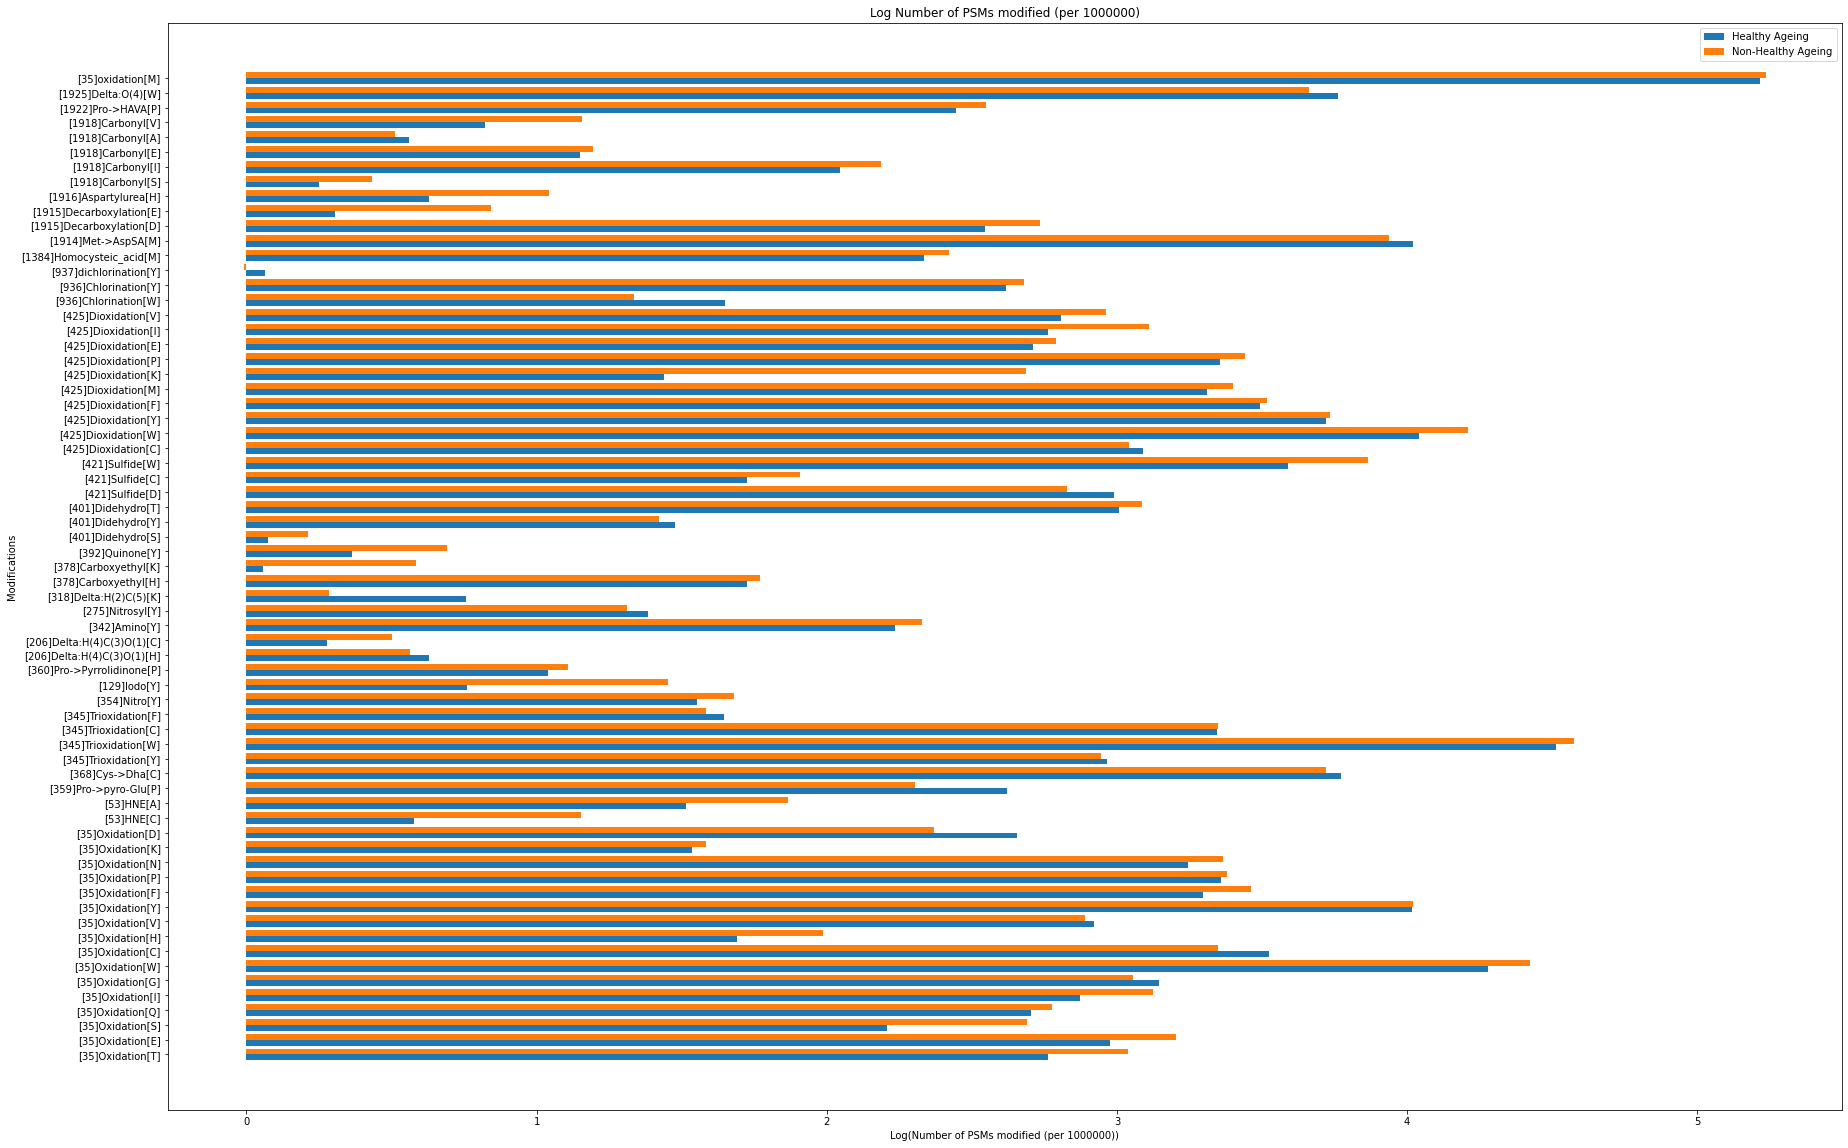

In [13]:
y = modr["Modification"]
xnone = np.log10(modr['Ratios_H']*1000000)
xH = np.log10(modr['Ratios_NH']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'Healthy Ageing')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'Non-Healthy Ageing')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of PSMs modified (per 1000000))")
plt.title("Log Number of PSMs modified (per 1000000)")

plt.legend()
plt.show()

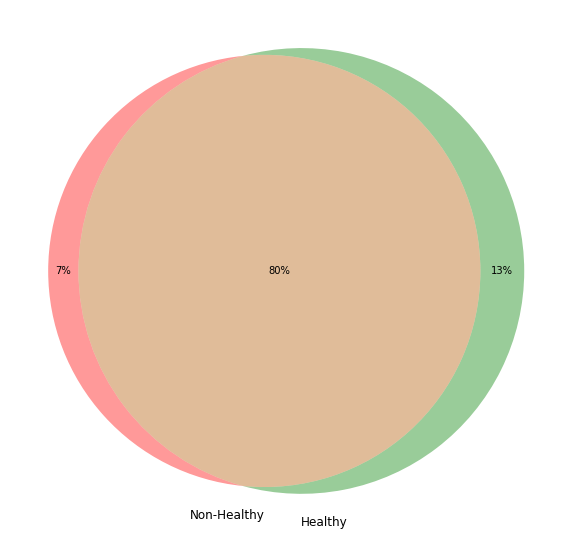

In [14]:
OA.condition_venn([NHrep,Hrep], ["Non-Healthy", "Healthy"])

In [15]:
difflist, pf_only_treatment = OA.comparelist(NHrep, Hrep)
pf_only_treatment.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
22364,0_4091_1,1DLC0080815QE_RRAG_002_rep1,1124.56150,11245.6479,2192.88918,2,KASYIDCIR,KASYIDCIR,7|[4]carbamidomethyl[C],7|57.0215,...,None,0,0,0,NaN,First,KASYIDC[4]carbamidomethylIR,7,[4]carbamidomethyl[C],False
22425,0_4213_2,1DLC0080815QE_RRAG_002_rep1,1124.56077,11245.6479,2214.10302,2,KASYIDCIR,KASYIDCIR,7|[4]carbamidomethyl[C],7|57.0215,...,None,0,0,0,NaN,First,KASYIDC[4]carbamidomethylIR,7,[4]carbamidomethyl[C],False
22530,0_4466_1,1DLC0080815QE_RRAG_002_rep1,1159.48191,11594.8555,2269.33242,2,SDVMYTDWK,SDVMYTDWK,4|[35]oxidation[M],4|15.9949,...,None,0,0,0,NaN,First,SDVM[35]oxidationYTDWK,4,[35]oxidation[M],True
22570,0_4562_1,1DLC0080815QE_RRAG_002_rep1,1159.48130,11594.8555,2290.76466,2,SDVMYTDWK,SDVMYTDWK,4|[35]oxidation[M],4|15.9949,...,None,0,0,0,NaN,First,SDVM[35]oxidationYTDWK,4,[35]oxidation[M],True
22578,0_4579_1,1DLC0080815QE_RRAG_002_rep1,1995.90633,19959.2208,2293.89780,3,NECFIQHKDDNPNIPR,NECFIQHKDDNPNIPR,3|[4]carbamidomethyl[C],3|57.0215,...,None,0,0,0,NaN,First,NEC[4]carbamidomethylFIQHKDDNPNIPR,3,[4]carbamidomethyl[C],False


In [16]:
onlytreatment = OA.modcounts(pf_only_treatment)
onlytreatment = onlytreatment.sort_values("Counts", ascending=False).drop(onlytreatment[onlytreatment["Counts"] == 0].index, axis=0)
onlytreatment

,Modification,Counts
129,[35]oxidation[M],6497
8,[35]Oxidation[W],2982
32,[345]Trioxidation[W],2035
85,[425]Dioxidation[I],1925
15,[35]Oxidation[F],1303
77,[425]Dioxidation[W],1128
5,[35]Oxidation[I],1125
74,[421]Sulfide[W],1101
1,[35]Oxidation[E],856
0,[35]Oxidation[T],807


In [17]:
RPMH = OA.relative_PSM_modification(Hrep)
RPMNH = OA.relative_PSM_modification(NHrep)

In [18]:
RPM = pd.merge(RPMH,RPMNH, on="Amino acid", suffixes=('_H', '_NH'))
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_H,Relative level of PSMs containing unmodified residue_NH
0,A,0.997788,0.998003
1,R,0.999596,0.999512
2,N,0.970901,0.974015
3,D,0.994760,0.995557
4,C,0.032009,0.030566
5,Q,0.994747,0.994759
6,E,0.994192,0.992131
7,G,0.998093,0.998627
8,H,0.985067,0.979621
9,I,0.997205,0.994451


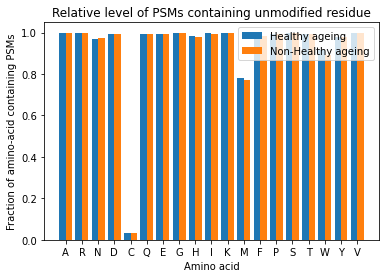

In [19]:
x = RPM["Amino acid"]
xnone = RPM["Relative level of PSMs containing unmodified residue_H"]
xH = RPM['Relative level of PSMs containing unmodified residue_NH']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'Healthy ageing')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'Non-Healthy ageing')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

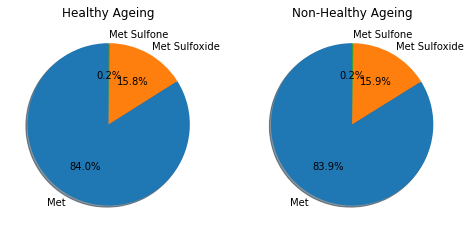

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.methionine_overview(Hrep, ax1)
OA.methionine_overview(NHrep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy Ageing")
plt.show()

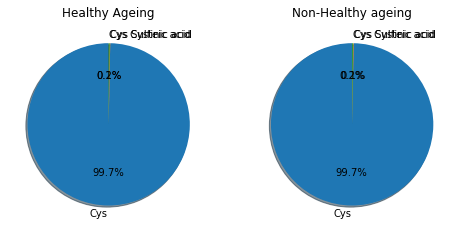

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.cysteine_overview(Hrep, ax1)
OA.cysteine_overview(NHrep, ax2)
plt.title("cysteine containing peptides")
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy ageing")
plt.show()

In [27]:
importlib.reload(OA)
diffox, statement = OA.differentially_oxidized_psms(NHrep, Hrep)
with open("diffoxPXD012477.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()

In [26]:
NHrep[(NHrep["Peptidoform_name"] == "NYISQYSEIAIQMMMHMQPK") & (NHrep["Oxidatively_modified"] == True)]

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
2280942,0_26953_1,1DLC071515QE_RRAG_062B_rep2,2474.09675,24421.2036,6514.881,2,NYISQYSEIAIQMMMHMQPK,NYISQYSEIAIQMMMHMQPK,x|[425]Dioxidation[M],0|,...,None,0,0,0,NaN,First,NYISQYSEIAIQMMMHMQPK,x,[425]Dioxidation[M],True


## Quantitative-based analysis

In [5]:
quant = pd.read_csv("/home/robbe/ionbot/PXD012477/raw_files/QuantifiedPeptides.tsv", sep= "\t")
quant.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Detection Type_1DLC012615QE_RRAG_008B_rep4,Detection Type_1DLC120914QE_RRAG_009_rep1,Detection Type_1DLC120914QE_RRAG_009_rep2,Detection Type_1DLC120914QE_RRAG_009_rep3,Detection Type_1DLC120914QE_RRAG_009_rep4,Detection Type_1DLC012615QE_RRAG_009B_rep1,Detection Type_1DLC012615QE_RRAG_009B_rep2,Detection Type_1DLC012615QE_RRAG_009B_rep3,Detection Type_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,0.0,0.0,2.594755e+06,2.694308e+06,6.799320e+05,...,MBR,MBR,MBR,NotDetected,NotDetected,MBR,NotDetected,MBR,NotDetected,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NotDetected,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,0.0,0.0,5.114359e+05,0.000000e+00,1.310336e+06,...,MBR,MBR,NotDetected,MBR,MBR,MBR,MBR,NotDetected,NotDetected,NaN


Doel: voor iedere oxMod intensiteiten plotten per subject (gemiddelde van de replicates), die puntjes allemaal in een boxplot, opgesplitst in Healthy and Non-Healthy

In [6]:
from pyteomics import mass as pymass
db = pymass.Unimod()
modslist = []
for p in range(len(db.mods)):
    for pp in db.mods[p]['specificity']:
        if db.mods[p]['record_id'] in [35, 53, 129, 130, 205, 206, 275, 288, 318, 319, 335, 340, 342, 344, 345, 348, 349, 350, 351, 352, 354, 
        359, 360, 368, 378, 392, 401, 421, 425, 534, 540, 548, 569, 720, 721, 743, 743, 860, 936, 936, 937, 949, 1384, 1914, 1915, 1916, 1917, 1918, 
        1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929]:
            t = db.mods[p]['title']
            t = t.replace("[",":").replace("]",":")
            mod = "[" + str(db.mods[p]['record_id']) + "]" + t + "[" + pp['site'] + "]"
            modslist.append(mod)
modslist.append('[35]oxidation[M]')


In [7]:
importlib.reload(OA)

<module 'OxiAnalysis' from '/home/robbe/ionbot/OxiAnalysis.py'>

In [8]:
from cmath import nan


def flashLFQmods(str):
    lijst = str.split("|")
    result = lijst[1::2]
    if len(result) == 0:
        return nan
    elif len(result) == 1:
        return result[0]
    return result

In [9]:
quant["Modifications"] = quant["Sequence"].apply(flashLFQmods)
quantex = quant.explode("Modifications")

In [10]:
quantex["Oxmod?"] = quantex["Modifications"].apply(OA.oxidatively_modified)

In [11]:
quantexox = quantex[quantex["Oxmod?"] == True]
quantexox.drop(list(quantexox.filter(regex = 'Detection Type')), axis = 1, inplace = True)
quantexox.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983,Modifications,Oxmod?
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,0.0,0.0,2.594755e+06,2.694308e+06,6.799320e+05,...,706419.812866,0.00000,0.000000,17318.227194,0.000000,13567.96196,0.0,NaN,[1927]Delta:H(4)C(5)O(1)[R],True
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,NaN,[1918]Carbonyl[R],True
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,NaN,[1918]Carbonyl[A],True
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,0.0,0.0,5.114359e+05,0.000000e+00,1.310336e+06,...,0.000000,55943.25161,15744.636755,93336.883774,64337.475246,0.00000,0.0,NaN,[205]Delta:H(6)C(6)O(1)[K],True
15,AAAAQISITQISSGNPVYEK10|[1918]Carbonyl[Q],AAAAQISITQISSGNPVYEK,NaN,NaN,NaN,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,NaN,[1918]Carbonyl[Q],True


In [12]:
summedintensities = quantexox.groupby("Modifications").sum().reset_index()
summedintensities

,Modifications,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,Intensity_1DLC012615QE_RRAG_001B_rep2,Intensity_1DLC012615QE_RRAG_001B_rep3,...,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983,Oxmod?
0,[129]Iodo[H],0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,4
1,[129]Iodo[Y],0.0,0.0,1.599770e+05,1.156199e+05,1.601283e+06,0.000000e+00,2.366426e+05,1.919372e+05,0.000000,...,3.141710e+06,1.375392e+06,0.000000e+00,82408.434881,4.187870e+05,4.391106e+05,2.280457e+05,4.949827e+05,0.0,21
2,[1384]Homocysteic_acid[M],0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.878168e+04,0.000000,...,0.000000e+00,0.000000e+00,7.964694e+03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,9.973323e+03,0.0,72
3,[1914]Met->AspSA[M],0.0,0.0,7.845126e+05,1.553652e+06,9.136819e+06,8.916667e+06,5.722646e+06,3.935119e+06,92177.800568,...,7.829988e+06,6.502185e+06,2.490279e+06,591578.097300,2.482146e+06,1.742120e+06,3.554580e+06,2.590534e+06,0.0,165
4,[1915]Decarboxylation[D],0.0,0.0,1.030694e+06,8.474852e+05,1.425481e+07,1.598241e+07,4.820578e+06,3.312639e+06,31813.559527,...,5.660662e+06,8.280999e+06,2.828533e+05,789334.882592,2.307601e+06,1.550096e+06,1.279008e+06,1.019635e+06,0.0,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,[936]Chlorination[W],0.0,0.0,0.000000e+00,0.000000e+00,1.359215e+06,1.685053e+06,3.572285e+05,3.463017e+05,0.000000,...,1.852901e+06,1.129806e+06,9.747668e+03,30799.151248,4.383085e+05,9.265683e+04,3.213986e+04,3.166659e+05,0.0,107
110,[936]Chlorination[Y],0.0,0.0,1.276883e+05,1.834337e+05,5.831574e+05,0.000000e+00,1.882222e+06,8.964342e+05,3573.883319,...,7.727732e+04,1.264311e+06,6.025922e+04,53551.491832,2.114631e+05,1.638811e+05,2.242542e+05,2.234977e+05,0.0,132
111,[937]dichlorination[C],0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10
112,[937]dichlorination[Y],0.0,0.0,1.291914e+05,3.223495e+04,1.172515e+06,4.199030e+06,1.178892e+06,8.983174e+05,5586.180827,...,0.000000e+00,0.000000e+00,0.000000e+00,144102.268949,0.000000e+00,6.490542e+04,2.332051e+05,1.550108e+05,0.0,24


In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for c in [c for c in summedintensities.columns if summedintensities[c].dtype in numerics]:
    summedintensities[c] = np.log2(summedintensities[c])

In [14]:
summedintensities = summedintensities.replace(float('-inf'), 0)

In [15]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in range(1,66):
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = summedintensities[[col for col in summedintensities if patient in col]]
    selected["Modifications"] = summedintensities["Modifications"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = summedintensities[[col for col in summedintensities if patientB in col]]
    selected["Modifications"] = summedintensities["Modifications"]
    dict[patientB] = selectedB
    
    


In [16]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

In [17]:
dict["_001_"]["median"]

0       0.000000
1      17.053268
2       0.000000
3      21.827653
4      21.870065
         ...    
109    10.187171
110    17.223583
111     0.000000
112    18.570163
113    19.230319
Name: median, Length: 114, dtype: float64

Nu heb ik df per subject met median values per modificatie ==> moet naar df per subject per modificatie

In [18]:
moddf = pd.DataFrame()
moddf["Modifications"] = summedintensities["Modifications"]
for patient in dict:
    moddf[patient] = dict[patient]["median"]

In [19]:
moddf = moddf.dropna(axis=1)
moddf

,Modifications,_001_,_002_,_003_,_004_,_005_,_006_,_007_,_008_,_009_,...,_053B_,_054B_,_055B_,_056B_,_058B_,_059B_,_060B_,_061B_,_062B_,_064B_
0,[129]Iodo[H],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,[129]Iodo[Y],17.053268,17.882812,16.313027,8.189331,18.607635,9.223323,18.412695,9.687773,18.360958,...,19.079111,18.162643,18.355596,18.932843,18.720477,18.156176,19.147645,18.892518,16.814510,17.651315
2,[1384]Homocysteic_acid[M],0.000000,0.000000,0.000000,0.000000,7.712062,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,14.954606,0.000000,0.000000,0.000000,0.000000,0.000000,15.201602,0.000000
3,[1914]Met->AspSA[M],21.827653,22.458742,20.166113,22.776572,22.177816,22.371186,22.501960,22.461007,21.940185,...,18.830940,20.880412,21.268279,20.491010,18.585770,16.241691,20.603661,20.285012,17.326387,18.865106
4,[1915]Decarboxylation[D],21.870065,22.475681,22.505768,22.750611,22.398404,22.819000,22.985656,22.083720,21.011409,...,20.323519,19.169287,19.649424,19.553750,19.614552,19.616760,20.441752,20.005169,20.283702,19.661216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,[936]Chlorination[W],10.187171,18.339497,19.122047,17.692748,20.058593,19.354450,20.064372,19.357768,17.509124,...,21.365250,18.856265,17.306638,14.905849,14.989164,16.409040,16.128259,20.123950,18.850083,6.485419
110,[936]Chlorination[Y],17.223583,15.986524,18.950456,7.266976,19.881821,20.347785,16.090185,19.214977,16.058326,...,17.339634,16.409922,16.541887,16.838686,18.135647,16.212292,16.168308,18.269757,15.499573,17.748214
111,[937]dichlorination[C],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
112,[937]dichlorination[Y],18.570163,9.858263,0.000000,10.496197,18.907679,8.357569,17.435039,20.907669,0.000000,...,0.000000,0.000000,0.000000,0.000000,16.465250,0.000000,0.000000,8.226776,0.000000,0.000000


In [20]:
Healthydf = pd.DataFrame()
NonHealthydf = pd.DataFrame()
Healthydf["Modifications"] = summedintensities["Modifications"]
NonHealthydf["Modifications"] = summedintensities["Modifications"]
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
patienlist = []
patienBlist = []
for i in Healthy:
    patien = "_"+str(i).zfill(3)+"_"
    patienlist.append(patien)
    patienB = "_"+str(i).zfill(3)+"B_"
    patienBlist.append(patienB)

for i in patienlist:
    if i in moddf.columns:
        Healthydf[i] = moddf[i]
for i in patienBlist:
    if i in moddf.columns:
        Healthydf[i] = moddf[i]
    

In [21]:
Healthydf

,Modifications,_001_,_003_,_004_,_005_,_006_,_011_,_013_,_014_,_019_,...,_037B_,_040B_,_041B_,_042B_,_047B_,_052B_,_054B_,_056B_,_060B_,_061B_
0,[129]Iodo[H],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,[129]Iodo[Y],17.053268,16.313027,8.189331,18.607635,9.223323,17.662439,8.646408,19.537586,8.546480,...,20.469793,18.674465,19.941734,19.645809,18.617030,15.048676,18.162643,18.932843,19.147645,18.892518
2,[1384]Homocysteic_acid[M],0.000000,0.000000,0.000000,7.712062,0.000000,8.507501,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.792365,0.000000,0.000000,0.000000,0.000000,0.000000
3,[1914]Met->AspSA[M],21.827653,20.166113,22.776572,22.177816,22.371186,21.723229,23.346323,22.518333,20.407822,...,20.222486,20.122544,19.110896,19.680204,19.610103,17.486598,20.880412,20.491010,20.603661,20.285012
4,[1915]Decarboxylation[D],21.870065,22.505768,22.750611,22.398404,22.819000,21.741928,21.693166,21.802110,21.351124,...,21.950005,19.934301,21.664559,20.851128,20.592697,17.452033,19.169287,19.553750,20.441752,20.005169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,[936]Chlorination[W],10.187171,19.122047,17.692748,20.058593,19.354450,16.669570,19.225845,17.694756,16.310801,...,13.594376,14.156775,12.325741,6.049544,15.493453,15.733108,18.856265,14.905849,16.128259,20.123950
110,[936]Chlorination[Y],17.223583,18.950456,7.266976,19.881821,20.347785,20.431400,18.292035,19.375303,17.871158,...,18.375193,17.158388,16.143376,19.815069,18.921431,15.479063,16.409922,16.838686,16.168308,18.269757
111,[937]dichlorination[C],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
112,[937]dichlorination[Y],18.570163,0.000000,10.496197,18.907679,8.357569,18.257077,9.328442,20.112309,0.000000,...,16.455443,0.000000,19.371088,18.597557,18.011262,14.787431,0.000000,0.000000,0.000000,8.226776


In [22]:
NonHealthydf = pd.DataFrame()
patielist = []
patieBlist = []
NonHealthydf["Modifications"] = summedintensities["Modifications"]
for i in NonHealthy:
    patie = "_"+str(i).zfill(3)+"_"
    patielist.append(patie)
    patieB = "_"+str(i).zfill(3)+"B_"
    patieBlist.append(patieB)

for i in patielist:
    if i in moddf.columns:
        NonHealthydf[i] = moddf[i]
for i in patieBlist:
    if i in moddf.columns:
        NonHealthydf[i] = moddf[i]
        
    

In [43]:
import scipy.stats as stats
import seaborn as sns
from statannot import add_stat_annotation

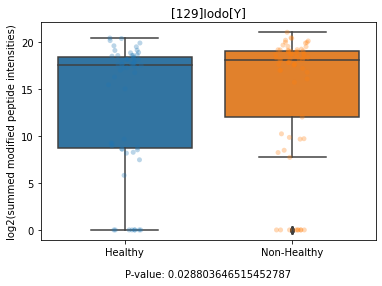

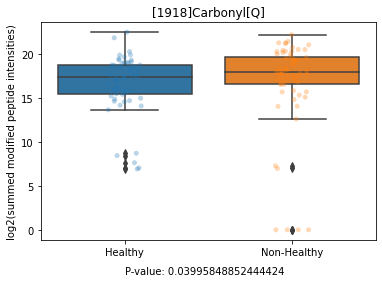

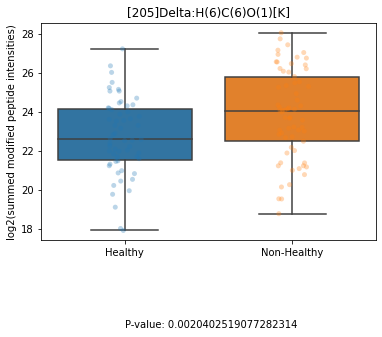

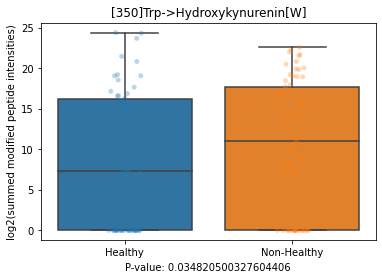

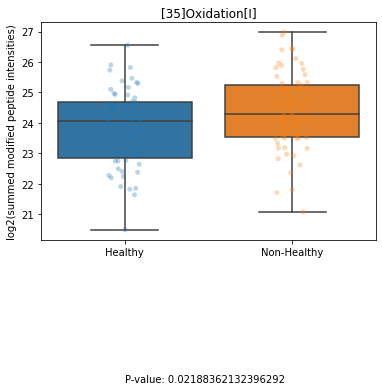

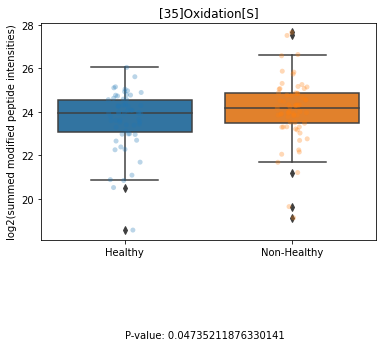

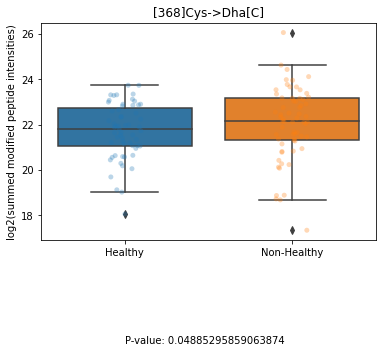

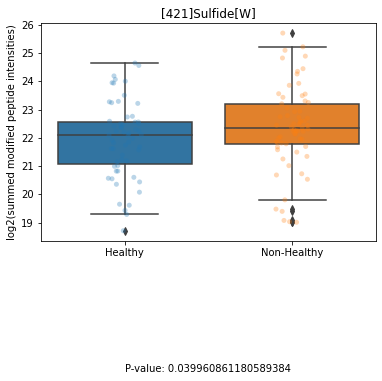

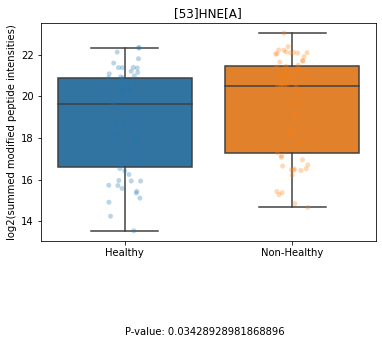

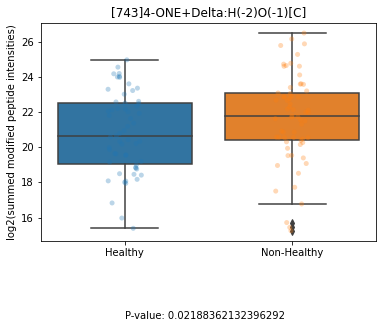

In [100]:
for index, row in Healthydf.iterrows():
    for index2, row2 in NonHealthydf.iterrows():
        if index == index2:
            mod = row["Modifications"]
            dataH = Healthydf.iloc[index][1:]
            dataH = dataH.astype(float)
            dataNH = NonHealthydf.iloc[index][1:]
            dataNH = dataNH.astype(float)
            data = [dataH, dataNH]
            n_of_tests = Healthydf.shape[0]
            #One-sided Mann-Whitney U test
            pval = stats.mannwhitneyu(dataH,dataNH, alternative = 'less').pvalue 
            if pval < 0.05: #TODO: #6 Multiple hypothesis testing correction needed?
                formatted_pvalue = [f'p={pval:.2e}']
                fig = plt.figure()
                ax = sns.boxplot(data=data)
                sns.stripplot(data=data, alpha = 0.3)
                ax.set_xticks(range(2))
                ax.set_xticklabels(["Healthy","Non-Healthy"])
                plt.text(x = 0, y = min(min(dataH), min(dataNH))-5, s="P-value: {}".format(pval))
                plt.title(mod)
                plt.ylabel("log2(summed modified peptide intensities)")
            
            
            
             
